## Model Testing and Analysis

This notebook applies the model to the training and validation sets for evaluation and predictions.

In [206]:
"""
Import libraries, load the training and validation data and initiate dataloaders.
"""
import os
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from dataset import DFUDataset
from loss import DiceLoss, BCEWithLogitsLoss, IOU
from optimiser import SGD, Adam
from model import UNet, DeepLabV3_MobileNet_V3_Large
from readFiles import ReadFiles
from training import Train
import numpy as np
import pandas as pd

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns

def ReadDirectories():
    print("Reading files from directories.")
    data_path = ""
    # Set training directory
    train_dir = os.path.join(data_path, "dfuc2022/train/images")
    train_mask_dir = os.path.join(data_path, "dfuc2022//train/masks")

    # Set validation directory
    val_dir = os.path.join(data_path, "dfuc2022/val/images")
    val_mask_dir = os.path.join(data_path, "dfuc2022/val/masks")

    # Set test directory
    test_dir = os.path.join(data_path, "dfuc2022/test/")

    train_files = ReadFiles(train_dir)
    train_masks = ReadFiles(train_mask_dir)

    val_files = ReadFiles(val_dir)
    val_masks = ReadFiles(val_mask_dir)

    test_files = ReadFiles(test_dir)
    print("Complete.")

    return train_files, train_masks, val_files, val_masks, test_files

def Transforms():
    transform_train = A.Compose([
        #A.augmentations.dropout.cutout.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.RandomBrightnessContrast(p=0.2),
        #ToTensorV2(),
        #A.augmentations.transforms.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5),
        #A.augmentations.geometric.transforms.ShiftScaleRotate(
        #    shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, p=0.5),
        ToTensorV2(),
    ])

    transform_test = A.Compose([
        ToTensorV2(),
    ])

    return transform_train, transform_test


# Read directories into file lists.
train_files, train_masks, val_files, val_masks, test_files = ReadDirectories()

# Get transformations from Transforms()
transform_train, transform_test = Transforms()

# Generate manual seed for reproducability
torch.manual_seed(42)

# Load dataset
print("Loading datasets...")
train_ds = DFUDataset(train_files, train_masks, transform=transform_train)
val_ds = DFUDataset(val_files, val_masks, transform=transform_test)
print("Complete.")

# Initiate DataLoader
train_iter = DataLoader(train_ds, 1, shuffle=False, pin_memory=True)
val_iter = DataLoader(val_ds, 1, shuffle=False, pin_memory=True)
print("Dataloader Initiated.")

loss = DiceLoss()

Reading files from directories.
Complete.
Loading datasets...
Complete.
Dataloader Initiated.


In [207]:
# Load baseline and best known model for evaluation.
model_path = './models/'

model = DeepLabV3_MobileNet_V3_Large()
model.load_state_dict(torch.load(os.path.join(model_path, 'DeepLabV3_Mobile/bestModel/model.pth'), 
                        map_location=torch.device('cpu')))

baseline = DeepLabV3_MobileNet_V3_Large()
baseline.load_state_dict(torch.load(os.path.join(model_path,  'DeepLabV3_Mobile/baseline_batchSize=16/model.pth'),
                            map_location=torch.device('cpu')))

DeepLab = True

model.eval()
baseline.eval()

print('Complete')

Complete


In [208]:
# Function to plot data point "i" using prediction model.
def plots(i, model):
    image, label = val_ds[i]
    output = model(image.unsqueeze(0))['out']
    print('Loss: ', loss(output, label))
    print('IOU: ', IOU(output, label, 'cpu'))

    outputs = torch.where(output < 0.5, input=torch.tensor(0.0), other=torch.tensor(1.0))

    fig, axs = plt.subplots(1, 3, figsize=(16,8))

    axs[0].imshow(image.permute(1,2,0));
    axs[1].imshow(outputs.squeeze(0).squeeze(0).detach().numpy());
    axs[2].imshow(label);

In [209]:
i = 6

Loss:  tensor(0.0427, grad_fn=<RsubBackward1>)
IOU:  tensor(0.9249)


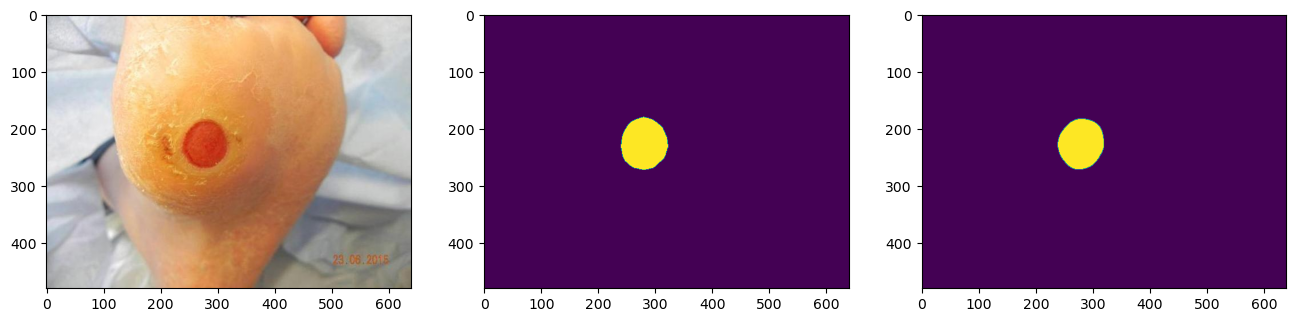

In [210]:
plots(i, model)

Loss:  tensor(0.0426, grad_fn=<RsubBackward1>)
IOU:  tensor(0.9178)


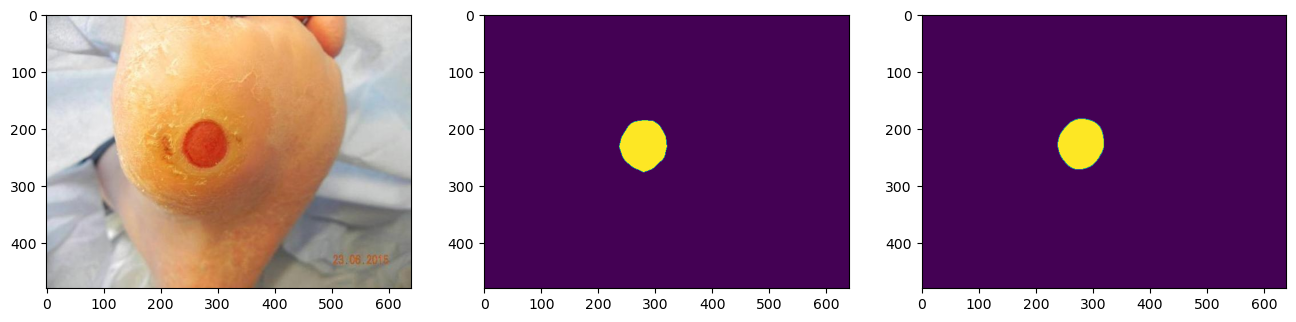

In [211]:
plots(i, baseline)

## Accuracy on Small or Large Wounds

In [212]:
# Load validation data info
val_info = pd.read_csv('val_info.csv')

In [213]:
# Get top and bottom 5% of observations based on label size.
lower, upper = np.percentile(val_info['labelSize'], [5, 95])
print('Lower bound: {}, Upper bound: {}'.format(lower, upper))

smallLabel = val_info.loc[val_info['labelSize'] < lower]
largeLabel = val_info.loc[val_info['labelSize'] > upper]

iSmall = smallLabel['i'].astype('int')
iLarge = largeLabel['i'].astype('int')

# Get loss and IOU of small label sizes.
l, v = [], []
for i, j in zip(range(0,len(iSmall)), iSmall):
    image, label = val_ds[j]

    if DeepLab == True:
        output = model(image.unsqueeze(0))['out']
    else:
        output = model(image.unsqueeze(0))

    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Small Mean Loss: ', np.mean(l))
print('Small Mean IOU: ', np.mean(v))
print(' ')

# Get loss and IOU of large label sizes.
l, v = [], []
for i, j in zip(range(0,len(iLarge)), iLarge):
    image, label = val_ds[j]

    if DeepLab == True:
        output = model(image.unsqueeze(0))['out']
    else:
        output = model(image.unsqueeze(0))
    
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Large Mean Loss: ', np.mean(l))
print('Large Mean IOU: ', np.mean(v))

Lower bound: 510.96492156982424, Upper bound: 27280.216601562424
Small Mean Loss:  0.57956547
Small Mean IOU:  0.3414246
 
Large Mean Loss:  0.17446879
Large Mean IOU:  0.7482218


In [214]:
lower, upper = np.percentile(val_info['labelSize'], [20, 80])
print('Lower bound: {}, Upper bound: {}'.format(lower, upper))

smallLabel = val_info.loc[val_info['labelSize'] < lower]
largeLabel = val_info.loc[val_info['labelSize'] > upper]

iSmall = smallLabel['i'].astype('int')
iLarge = largeLabel['i'].astype('int')

l, v = [], []
for i, j in zip(range(0,len(iSmall)), iSmall):
    image, label = val_ds[j]

    if DeepLab == True:
        output = model(image.unsqueeze(0))['out']
    else:
        output = model(image.unsqueeze(0))
    
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Small Mean Loss: ', np.mean(l))
print('Small Mean IOU: ', np.mean(v))
print(' ')

l, v = [], []
for i, j in zip(range(0,len(iLarge)), iLarge):
    image, label = val_ds[j]

    if DeepLab == True:
        output = model(image.unsqueeze(0))['out']
    else:
        output = model(image.unsqueeze(0))
    
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Large Mean Loss: ', np.mean(l))
print('Large Mean IOU: ', np.mean(v))

Lower bound: 1013.5811767578125, Upper bound: 9941.748046875
Small Mean Loss:  0.4589127
Small Mean IOU:  0.44990143
 
Large Mean Loss:  0.13561079
Large Mean IOU:  0.786903


In [215]:
# Load training data info
train_info = pd.read_csv('train_info.csv')

In [216]:

lower, upper = np.percentile(train_info['labelSize'], [20, 80])
print('Lower bound: {}, Upper bound: {}'.format(lower, upper))

smallLabel = train_info.loc[train_info['labelSize'] < lower]
largeLabel = train_info.loc[train_info['labelSize'] > upper]

iSmall = smallLabel['i'].astype('int')
iLarge = largeLabel['i'].astype('int')

l, v = [], []
for i, j in zip(range(0,len(iSmall)), iSmall):
    image, label = train_ds[j]

    output = model(image.unsqueeze(0))['out']
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Small Mean Loss: ', np.mean(l))
print('Small Mean IOU: ', np.mean(v))
print(' ')

l, v = [], []
for i, j in zip(range(0,len(iLarge)), iLarge):
    image, label = train_ds[j]

    output = model(image.unsqueeze(0))['out']
    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Large Mean Loss: ', np.mean(l))
print('Large Mean IOU: ', np.mean(v))

Lower bound: 0.00357652950286862, Upper bound: 0.03339444224039707
Small Mean Loss:  0.3858902
Small Mean IOU:  0.51456225
 
Large Mean Loss:  0.05384351
Large Mean IOU:  0.90113413


In [217]:
# Function to plot data point "i" using prediction model.
def plots2(i, model1, model2):
    image, label = val_ds[i]
    output = model(image.unsqueeze(0))['out']
    outputs = torch.where(output < 0.5, input=torch.tensor(0.0), other=torch.tensor(1.0))

    output2 = model2(image.unsqueeze(0))['out']
    outputs2 = torch.where(output2 < 0.5, input=torch.tensor(0.0), other=torch.tensor(1.0))

    fig, axs = plt.subplots(1, 4, figsize=(16,4))

    axs[0].imshow(image.permute(1,2,0));
    axs[0].axis('off')
    axs[0].set_title('(A) Image', y=-0.18)

    axs[1].imshow(outputs.squeeze(0).squeeze(0).detach().numpy());
    axs[1].axis('off')
    axs[1].set_title('(B) Best Model', y=-0.18)

    axs[2].imshow(outputs2.squeeze(0).squeeze(0).detach().numpy());
    axs[2].axis('off')
    axs[2].set_title('(C) Baseline Model', y=-0.18)

    axs[3].imshow(label);
    axs[3].axis('off')
    axs[3].set_title('(D) Mask Label', y=-0.18)

    plt.tight_layout()
    plt.show()

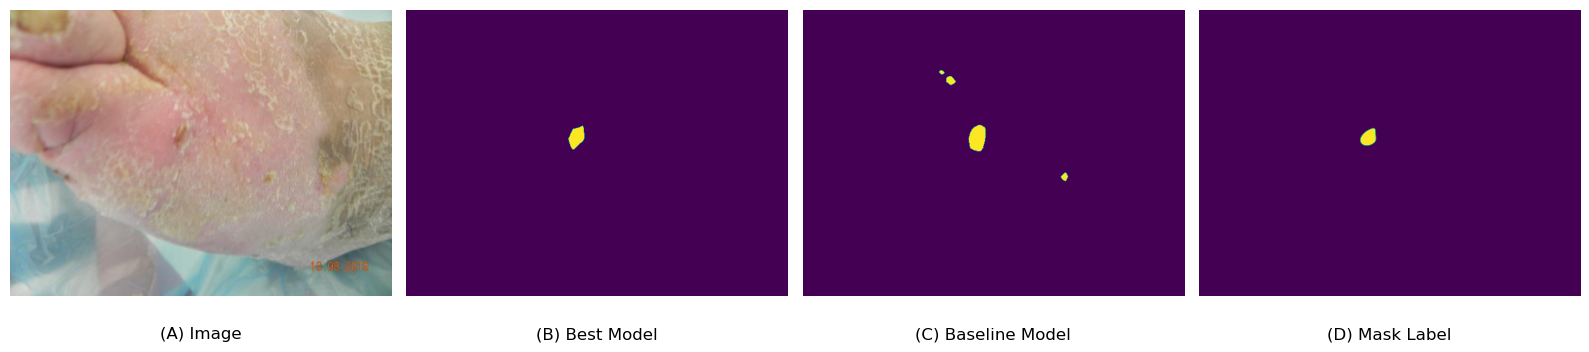

In [218]:
plots2(0, model, baseline)

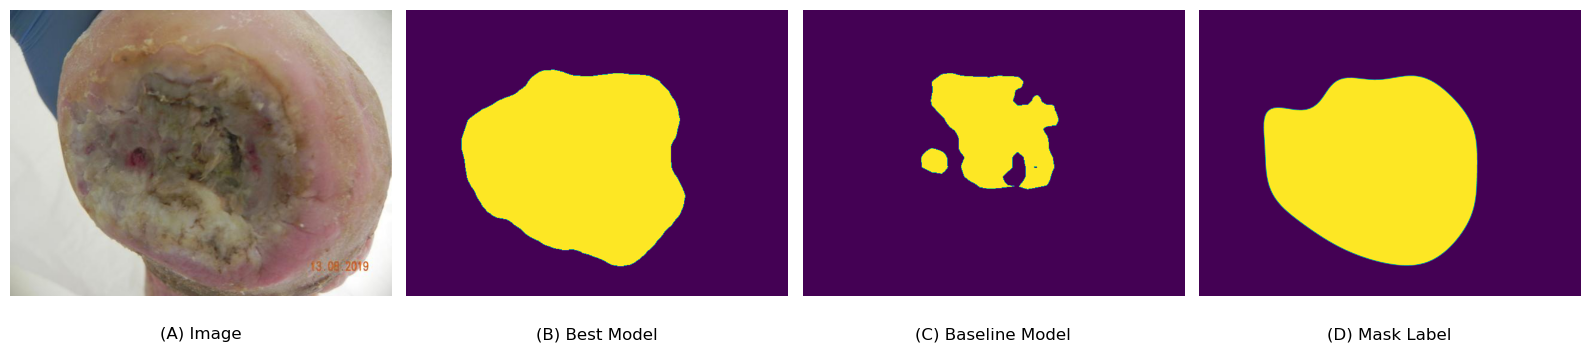

In [219]:
plots2(1, model, baseline)

## T-Test for Difference in Means

In [220]:
# Define function for returning loss and IOU arrays.
def evaluate(data, model):
    l, v = [], []
    for i, j in enumerate(data):
        image, label = j
        output = model(image)['out']
        l.append(loss(output, label).detach().numpy())
        v.append(IOU(output, label, 'cpu'))
        
    return l, v

In [221]:
# Evaluate baseline model
base_l, base_v = evaluate(val_iter, baseline)

# Print mean of IOU
np.mean(base_v)

0.61226827

In [222]:
# Evaluate best model
model_l, model_v = evaluate(val_iter, model)

# Print mean IOU
np.mean(model_v)

0.64245

In [223]:
import pandas as pd
data = pd.DataFrame(columns=['baseline','model'])

data['baseline'] = np.array(base_v)
data['model'] = np.array(model_v)
data.head()

,baseline,model
0,0.306744,0.753585
1,0.326643,0.896450
2,0.822759,0.798030
3,0.853904,0.913561
4,0.908640,0.906690


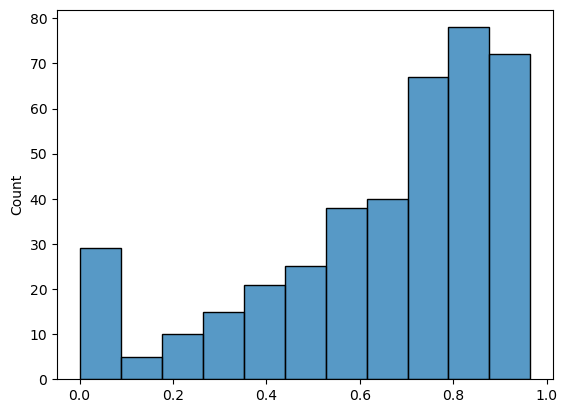

In [224]:
sns.histplot(np.array(model_v));

In [225]:
# Perform the MannWhitneyU Test for differece in means (non-parametric as not normally dist)
from scipy.stats import mannwhitneyu
mannwhitneyu(data['baseline'], data['model'], alternative='less')

MannwhitneyuResult(statistic=72766.0, pvalue=0.013427742147938355)

## Predictions

## Testing Phase

In [226]:
# Load baseline and best known model for evaluation.
model_path = './models/'

model = DeepLabV3_MobileNet_V3_Large()
model.load_state_dict(torch.load(os.path.join(model_path, 'DeepLabV3_Mobile/Validation/best/model.pth'), 
                        map_location=torch.device('cpu')))

baseline = DeepLabV3_MobileNet_V3_Large()
baseline.load_state_dict(torch.load(os.path.join(model_path,  'DeepLabV3_Mobile/Validation/baseline/model.pth'),
                            map_location=torch.device('cpu')))

DeepLab = True

model.eval()
baseline.eval()

print('Complete')

Complete


In [227]:
test_files = train_files[1400:]
test_masks = train_masks[1400:]

In [228]:
test_ds = DFUDataset(test_files, test_masks, transform=transform_test)

In [229]:
test_iter = DataLoader(test_ds, 16, shuffle=False, pin_memory=True)

In [230]:
# Get loss and IOU of small label sizes.
l, v = [], []
for i, data in enumerate(test_iter):
    image, label = data

    if DeepLab == True:
        output = model(image)['out']
    else:
        output = model(image)

    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Mean Loss: ', np.mean(l))
print('Mean IOU: ', np.mean(v))
print(' ')

Mean Loss:  0.21769898
Mean IOU:  0.65977675
 


In [231]:
# Get loss and IOU of small label sizes.
l, v = [], []
for i, data in enumerate(test_iter):
    image, label = data

    if DeepLab == True:
        output = baseline(image)['out']
    else:
        output = baseline(image)

    l.append(loss(output, label).detach().numpy())
    v.append(IOU(output, label, 'cpu'))

print('Mean Loss: ', np.mean(l))
print('Mean IOU: ', np.mean(v))
print(' ')

Mean Loss:  0.21832837
Mean IOU:  0.6495559
 
